In [5]:
import tensorflow as tf
import tensorflow_hub as hub
# For saving 'feature vectors' into a txt file
import numpy as np
# Glob for reading file names in a folder
import glob
import os.path
import os
from tqdm import tqdm
import ntpath
import warnings
import cv2
from annoy import AnnoyIndex
from scipy import spatial
warnings.filterwarnings('ignore')
from operator import itemgetter

In [2]:
!pip install annoy

     |████████████████████████████████| 646 kB 7.2 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391661 sha256=07bbd45a919e00f8e439cd4ec0d85829971fac5f49dd8395456d79afd6b4574e
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def load_img(path):
    # Reads the image file and returns data type of string
    img = tf.io.read_file(path)
    # Decodes the image to W x H x 3 shape tensor with type of uint8
    img = tf.io.decode_jpeg(img, channels=3)
    # Resizes the image to 224 x 224 x 3 shape tensor
    img = tf.image.resize_with_pad(img, 224, 224)
    # Converts the data type of uint8 to float32 by adding a new axis
    # img becomes 1 x 224 x 224 x 3 tensor with data type of float32
    # This is required for the mobilenet model we are using
    img = tf.image.convert_image_dtype(img,tf.float32)[tf.newaxis, ...]

    return img

In [7]:
def match_id(filename):
    product_id = '_'.join(filename.split('_')[:-1])
    return product_id

In [8]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list
root_dir = '/content/drive/MyDrive/Images/'
filenames = sorted(get_file_list(root_dir))

In [19]:
import glob
image_paths = glob.glob('/content/drive/MyDrive/Images/Input/*.jpg')

In [25]:
image_paths = image_paths[:100]

In [26]:
len(image_paths)

100

In [27]:
def get_image_feature_vectors(path):
    module_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4"
    # Loads the module
    module = hub.load(module_handle)
    # Loops through all images in a local folder

    #print(path)
    # Loads and pre-process the image
    img = load_img(path)
    # Calculate the image feature vector of the img
    features = module(img)
    # Remove single-dimensional entries from the 'features' array  
    feature_set = np.squeeze(features)

    # Saves the image feature vectors into a file for later use
    outfile_name = os.path.basename(filename) + ".npz"

    out_path = os.path.join('/content/drive/MyDrive/Images/Input/',outfile_name)
    # Saves the 'feature_set' to a text file
    np.savetxt(out_path, feature_set, delimiter=',')

In [23]:
def get_features(img, image_path): 
     # Definition of module with using tfhub.dev
    module_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4"
    # Loads the module
    module = hub.load(module_handle)
    features = module(img)
    # Remove single-dimensional entries from the 'features' array  
    feature_set = np.squeeze(features)
    #print(image_path)

    # Saves the image feature vectors into a file for later use
    outfile_name = os.path.basename(image_path) + ".npz"

    out_path = os.path.join('/content/drive/MyDrive/Images/Input/',outfile_name)
    # Saves the 'feature_set' to a text file
    np.savetxt(out_path, feature_set, delimiter=',')
    vector = np.loadtxt(out_path)
    return vector
    

In [28]:
#image_paths= glob.glob('/content/drive/MyDrive/Images/Input/*.jpg')
vectorfiles = glob.glob('/content/drive/MyDrive/Images/Input/*.npz')
# compute styles
image_style_embeddings = {}

for image_path in tqdm(image_paths): 
    image_tensor = load_img(image_path)
    vector = get_features(image_tensor, image_path)
    image_style_embeddings[ntpath.basename(image_path)] = vector
    

100%|██████████| 100/100 [05:11<00:00,  3.12s/it]


In [29]:
def cluster():
    print("-------Annoy Index Generation----------------")
    # Defining data structures as empty dict
    file_index_to_file_name = {}
    file_index_to_file_vector = {}
    file_index_to_product_id = {}
    # Configuring annoy parameters
    dims = 1792
    n_nearest_neighbors = 20
    trees = 10000
    # Reads all file names which stores feature vectors
    allfiles = glob.glob('/content/drive/MyDrive/Images/Input/*.npz')

    t = AnnoyIndex(dims, metric='angular')
    
    for file_index, i in enumerate(allfiles):
    # Reads feature vectors and assigns them into the file_vector 
        file_vector = np.loadtxt(i)

        # Assigns file_name, feature_vectors and corresponding product_id
        file_name = os.path.basename(i).split('.')[0]
        file_index_to_file_name[file_index] = file_name
        file_index_to_file_vector[file_index] = file_vector
        file_index_to_product_id[file_index] = match_id(file_name)

        # Adds image feature vectors into annoy index   
        t.add_item(file_index, file_vector)

        print("---------------------------------")
        print("Annoy index     : %s" %file_index)
        print("Image file name : %s" %file_name)
        print("Product id      : %s" %file_index_to_product_id[file_index])
        #print("--- %.2f minutes passed ---------" % ((time.time() - start_time)/60))


    # Builds annoy index
    t.build(trees)

    print ("Step.1 - ANNOY index generation - Finished")
    print ("Step.2 - Similarity score calculation - Started ") 
  
    global named_nearest_neighbors
    named_nearest_neighbors = []

  # Loops through all indexed items
    for i in file_index_to_file_name.keys():

    # Assigns master file_name, image feature vectors and product id values
        master_file_name = file_index_to_file_name[i]
        master_vector = file_index_to_file_vector[i]
        master_product_id = file_index_to_product_id[i]

        # Calculates the nearest neighbors of the master item
        nearest_neighbors = t.get_nns_by_item(i, n_nearest_neighbors)

        # Loops through the nearest neighbors of the master item
        for j in nearest_neighbors:

            # Assigns file_name, image feature vectors and product id values of the similar item
            neighbor_file_name = file_index_to_file_name[j]
            neighbor_file_vector = file_index_to_file_vector[j]
            neighbor_product_id = file_index_to_product_id[j]

            # Calculates the similarity score of the similar item
            similarity = 1 - spatial.distance.cosine(master_vector, neighbor_file_vector)
            rounded_similarity = int((similarity * 10000)) / 10000.0

            # Appends master product id with the similarity score 
            # and the product id of the similar items
            named_nearest_neighbors.append({
            'similarity': rounded_similarity,
            'master_pi': master_product_id,
            'similar_pi': neighbor_product_id})
#     print(named_nearest_neighbors)
#     print(type(named_nearest_neighbors))
            
#     return named_nearest_neighbors

In [30]:
#image_paths = glob.glob('/Users/rishabshekar/Downloads/Dataset/*.jpeg')
print(f'Founnd [{len(image_paths)}] images')

images = []
for image_path in image_paths:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (200, 200))
    product_id = match_id(ntpath.basename(image_path))
    images.append({
      'image_path' : ntpath.basename(image_path),
        'image' : image,
       'product_id':product_id
    })
#     images['image_path'] = ntpath.basename(image_path)
#     images['image'] = image
#     #images[ntpath.basename(image_path)] = image
#     product_id = match_id(ntpath.basename(image_path))
#     images['product_id'] = product_id

Founnd [100] images


In [31]:
cluster()

-------Annoy Index Generation----------------
---------------------------------
Annoy index     : 0
Image file name : img 102541img_00000038
Product id      : img 102541img
---------------------------------
Annoy index     : 1
Image file name : img 102113img_00000002
Product id      : img 102113img
---------------------------------
Annoy index     : 2
Image file name : img 102538img_00000035
Product id      : img 102538img
---------------------------------
Annoy index     : 3
Image file name : img 102556img_00000053
Product id      : img 102556img
---------------------------------
Annoy index     : 4
Image file name : img 102542img_00000039
Product id      : img 102542img
---------------------------------
Annoy index     : 5
Image file name : img 102546img_00000043
Product id      : img 102546img
---------------------------------
Annoy index     : 6
Image file name : img 102568img_00000065
Product id      : img 102568img
---------------------------------
Annoy index     : 7
Image file 

In [32]:
#named_nearest_neighbors=[]
cluster()
print("Printing named_nearest_neighbors")
print(named_nearest_neighbors)
print(type(named_nearest_neighbors))

-------Annoy Index Generation----------------
---------------------------------
Annoy index     : 0
Image file name : img 102541img_00000038
Product id      : img 102541img
---------------------------------
Annoy index     : 1
Image file name : img 102113img_00000002
Product id      : img 102113img
---------------------------------
Annoy index     : 2
Image file name : img 102538img_00000035
Product id      : img 102538img
---------------------------------
Annoy index     : 3
Image file name : img 102556img_00000053
Product id      : img 102556img
---------------------------------
Annoy index     : 4
Image file name : img 102542img_00000039
Product id      : img 102542img
---------------------------------
Annoy index     : 5
Image file name : img 102546img_00000043
Product id      : img 102546img
---------------------------------
Annoy index     : 6
Image file name : img 102568img_00000065
Product id      : img 102568img
---------------------------------
Annoy index     : 7
Image file 

In [34]:
print(image_paths[69])

/content/drive/MyDrive/Images/Input/img 102128img_00000017.jpg


In [35]:
from scipy import spatial
import matplotlib.pyplot as plt
def search_similar_image(reference_image, max_results):
    reference_image = '_'.join(reference_image.split('_')[:-1])
    print(reference_image)
    nearest = []
    #print(named_nearest_neighbors[1]['master_pi'])
    #f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i in range (0, len(named_nearest_neighbors)):
        if(named_nearest_neighbors[i]['master_pi'] == reference_image):
            nearest.append({
                'similarity' : named_nearest_neighbors[i]['similarity'],
                'master_pi' : named_nearest_neighbors[i]['master_pi'],
                'similar_pi' : named_nearest_neighbors[i]['similar_pi']
            })
    f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i in range(0, max_results):
        for j in range(0, len(images)):
            if(nearest[i]['similar_pi'] == images[j]['product_id']):
                ax[i].imshow(images[j]['image'])
                ax[i].set_axis_off()
                
    plt.show()

                
        

img 102128img


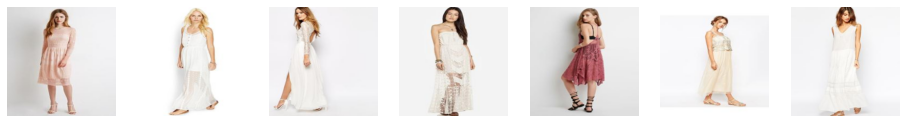

In [39]:
search_similar_image('img 102128img_00000017', 7)